In [1]:
import torch
import matplotlib.pyplot as plt

import online_gp
import gpytorch

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
gpytorch.__file__

'/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/__init__.py'

In [3]:
import pandas as pd

fx_rawdata = pd.read_csv('https://raw.githubusercontent.com/trungngv/cogp/master/data/fx/fx2007-processed.csv',
                        header=None)

inputs = torch.arange(0, fx_rawdata[3].shape[0]).view(-1,1).float()
targets = torch.from_numpy(fx_rawdata[3].values).float() 

inputs, targets = inputs[:60], targets[:60]

tmean = targets.mean()
tstd = targets.std()
targets = (targets - tmean) / tstd

imean = inputs.mean()
istd = inputs.std()
inputs = (inputs - imean) / istd

In [4]:
def fit_model(mll, model, optimizer, x, y, num_steps=1000, verbose=True):
    for i in range(num_steps):
        loss = -mll(model(x), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % (num_steps // 10 if num_steps > 10 else 1) == 0 and verbose:
            print("Loss: ", loss)

In [5]:
def make_basic_plot(model, x, y, old_x=None, old_y=None, bounds=(-6., 6.)):
    model.eval()
    with torch.no_grad():
        test_x = torch.linspace(*bounds).view(-1,1)
        pred_dist = vargp_model(test_x)
        pred_induc = vargp_model(vargp_model.variational_strategy.inducing_points.data.view(-1,1))
        
    plt.plot(test_x, pred_dist.mean, label = "Predictive Mean")
    plt.fill_between(test_x.view(-1), *[x.detach() for x in pred_dist.confidence_region()], alpha = 0.3)
    
    plt.scatter(x, y, color = "black", label = "Current Data")
    plt.scatter(vargp_model.variational_strategy.inducing_points.data, pred_induc.mean.detach(), 
            color = "red", marker="x", label = "Inducing Points")
    if old_x is not None:
        plt.scatter(old_x, old_y, color = "grey", alpha = 0.5, label = "Old Data")
        
    plt.legend()
    plt.xlabel("x", fontsize = 16)
    plt.ylabel("y", fontsize = 16)

## Fit in Online Mode


In [6]:
from torch import Tensor
from gpytorch.lazy import LazyTensor
from typing import Union

def _pivoted_cholesky_init(
    train_inputs: Tensor,
    kernel_matrix: Union[Tensor, LazyTensor],
    max_length: int,
    epsilon: float = 1e-10,
) -> Tensor:
    r"""
    A pivoted cholesky initialization method for the inducing points, originally proposed in
    [burt2020svgp] with the algorithm itself coming from [chen2018dpp]. Code is a PyTorch version from
    [chen2018dpp], copied from https://github.com/laming-chen/fast-map-dpp/blob/master/dpp.py.
    Args:
        train_inputs [Tensor]: training inputs
        kernel_matrix [Tensor or Lazy Tensor]: kernel matrix on the training inputs
        max_length [int]: number of inducing points to initialize
        epsilon [float]: numerical jitter for stability.
    """
    # this is numerically equivalent to iteratively performing a pivoted cholesky
    # while storing the diagonal pivots at each iteration
    # TODO: use gpytorch's pivoted cholesky instead once that gets an exposed list
    # TODO: this probably won't work in batch mode.
    item_size = kernel_matrix.shape[-2]
    cis = torch.zeros((max_length, item_size))
    di2s = kernel_matrix.diag()
    selected_items = []
    selected_item = torch.argmax(di2s)
    selected_items.append(selected_item)
    while len(selected_items) < max_length:
        k = len(selected_items) - 1
        ci_optimal = cis[:k, selected_item]
        di_optimal = torch.sqrt(di2s[selected_item])
        elements = kernel_matrix[..., selected_item, :]
        eis = (elements - torch.matmul(ci_optimal, cis[:k, :])) / di_optimal
        cis[k, :] = eis
        di2s = di2s - eis.pow(2.0)
        di2s[selected_item] = -(torch.tensor(float("inf")))
        selected_item = torch.argmax(di2s)
        if di2s[selected_item] < epsilon:
            break
        selected_items.append(selected_item)
    ind_points = train_inputs[torch.stack(selected_items)]
    return ind_points

In [7]:
cm = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
vargp_model = online_gp.models.VariationalGPModel(
    _pivoted_cholesky_init(inputs[:25], cm(inputs[:25]), 20), 
    streaming=False, 
    likelihood = likelihood,
    covar_module = cm,
    learn_inducing_locations=False,
)
mll = gpytorch.mlls.VariationalELBO(likelihood=likelihood, model=vargp_model, num_data=25, beta = 1.0)

optimizer = torch.optim.Adam(list(vargp_model.parameters()) + list(likelihood.parameters()), lr = 1e-2)

fit_model(mll, vargp_model, optimizer, inputs[:25], targets[:25])


/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/torch/optim/adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Loss:  tensor(2.7004, grad_fn=<NegBackward>)
Loss:  tensor(1.2496, grad_fn=<NegBackward>)
Loss:  tensor(0.8695, grad_fn=<NegBackward>)
Loss:  tensor(0.7381, grad_fn=<NegBackward>)
Loss:  tensor(0.7277, grad_fn=<NegBackward>)
Loss:  tensor(0.7275, grad_fn=<NegBackward>)
Loss:  tensor(0.7276, grad_fn=<NegBackward>)
Loss:  tensor(0.7275, grad_fn=<NegBackward>)
Loss:  tensor(0.7275, grad_fn=<NegBackward>)
Loss:  tensor(0.7278, grad_fn=<NegBackward>)


/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  after removing the cwd from sys.path.


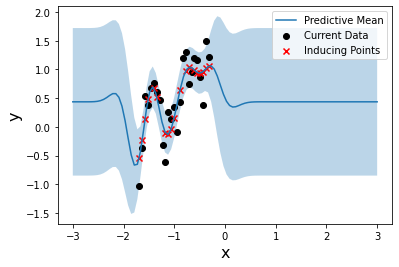

In [8]:
make_basic_plot(vargp_model, inputs[:25], targets[:25], bounds=(-3., 3))

In [9]:
%pdb

Automatic pdb calling has been turned ON


Starting step:  25
Loss:  tensor(24.2234, grad_fn=<NegBackward>)
Loss:  tensor(19.2719, grad_fn=<NegBackward>)
Loss:  tensor(11.8524, grad_fn=<NegBackward>)
Loss:  tensor(17.7625, grad_fn=<NegBackward>)


/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Loss:  tensor(17.6463, grad_fn=<NegBackward>)
Loss:  tensor(16.0789, grad_fn=<NegBackward>)
Loss:  tensor(19.0835, grad_fn=<NegBackward>)
Loss:  tensor(20.7279, grad_fn=<NegBackward>)
Loss:  tensor(19.8935, grad_fn=<NegBackward>)
Loss:  tensor(18.9060, grad_fn=<NegBackward>)
Starting step:  26
Loss:  tensor(16.2782, grad_fn=<NegBackward>)
Loss:  tensor(12.0007, grad_fn=<NegBackward>)
Loss:  tensor(9.9310, grad_fn=<NegBackward>)
Loss:  tensor(6.8610, grad_fn=<NegBackward>)
Loss:  tensor(2.1730, grad_fn=<NegBackward>)
Loss:  tensor(-9.9526, grad_fn=<NegBackward>)
Loss:  tensor(-39.4555, grad_fn=<NegBackward>)
Loss:  tensor(-101.4390, grad_fn=<NegBackward>)
Loss:  tensor(-216.3463, grad_fn=<NegBackward>)
Loss:  tensor(-411.7822, grad_fn=<NegBackward>)


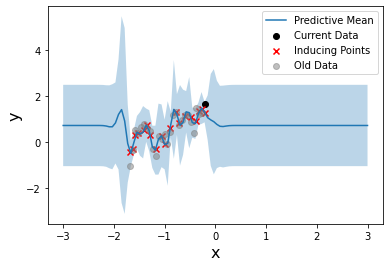

Starting step:  27
Loss:  tensor(16.9604, grad_fn=<NegBackward>)
Loss:  tensor(79.2958, grad_fn=<NegBackward>)
Loss:  tensor(121.8976, grad_fn=<NegBackward>)
Loss:  tensor(102.4937, grad_fn=<NegBackward>)
Loss:  tensor(114.9328, grad_fn=<NegBackward>)
Loss:  tensor(77.2715, grad_fn=<NegBackward>)
Loss:  tensor(111.0035, grad_fn=<NegBackward>)
Loss:  tensor(70.4321, grad_fn=<NegBackward>)
Loss:  tensor(73.0135, grad_fn=<NegBackward>)
Loss:  tensor(82.0763, grad_fn=<NegBackward>)
Starting step:  28
Loss:  tensor(14.4218, grad_fn=<NegBackward>)
Loss:  tensor(18.0288, grad_fn=<NegBackward>)
Loss:  tensor(20.3931, grad_fn=<NegBackward>)
Loss:  tensor(19.9801, grad_fn=<NegBackward>)
Loss:  tensor(20.9149, grad_fn=<NegBackward>)
Loss:  tensor(21.4722, grad_fn=<NegBackward>)
Loss:  tensor(21.4427, grad_fn=<NegBackward>)
Loss:  tensor(21.5626, grad_fn=<NegBackward>)
Loss:  tensor(21.0308, grad_fn=<NegBackward>)
Loss:  tensor(20.0124, grad_fn=<NegBackward>)


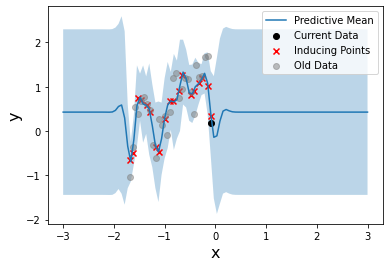

Starting step:  29
Loss:  tensor(16.1592, grad_fn=<NegBackward>)
Loss:  tensor(15.6672, grad_fn=<NegBackward>)
Loss:  tensor(15.0567, grad_fn=<NegBackward>)
Loss:  tensor(14.4780, grad_fn=<NegBackward>)
Loss:  tensor(14.0815, grad_fn=<NegBackward>)
Loss:  tensor(13.6808, grad_fn=<NegBackward>)
Loss:  tensor(13.4611, grad_fn=<NegBackward>)
Loss:  tensor(13.2238, grad_fn=<NegBackward>)
Loss:  tensor(13.0711, grad_fn=<NegBackward>)
Loss:  tensor(13.1136, grad_fn=<NegBackward>)
Starting step:  30
Loss:  tensor(9.0511, grad_fn=<NegBackward>)
Loss:  tensor(8.9848, grad_fn=<NegBackward>)
Loss:  tensor(9.0721, grad_fn=<NegBackward>)
Loss:  tensor(8.9858, grad_fn=<NegBackward>)
Loss:  tensor(8.9210, grad_fn=<NegBackward>)
Loss:  tensor(8.9106, grad_fn=<NegBackward>)
Loss:  tensor(8.9293, grad_fn=<NegBackward>)
Loss:  tensor(8.9407, grad_fn=<NegBackward>)
Loss:  tensor(8.9586, grad_fn=<NegBackward>)
Loss:  tensor(8.9490, grad_fn=<NegBackward>)


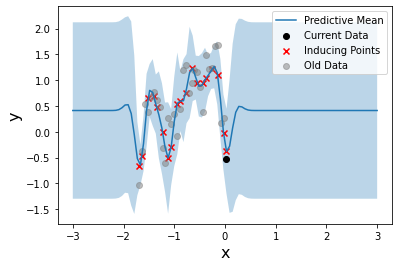

Starting step:  31
Loss:  tensor(16.2928, grad_fn=<NegBackward>)
Loss:  tensor(15.9027, grad_fn=<NegBackward>)
Loss:  tensor(15.4177, grad_fn=<NegBackward>)
Loss:  tensor(14.8431, grad_fn=<NegBackward>)
Loss:  tensor(14.2493, grad_fn=<NegBackward>)
Loss:  tensor(13.6876, grad_fn=<NegBackward>)
Loss:  tensor(13.2099, grad_fn=<NegBackward>)
Loss:  tensor(12.8128, grad_fn=<NegBackward>)
Loss:  tensor(12.5069, grad_fn=<NegBackward>)
Loss:  tensor(12.2742, grad_fn=<NegBackward>)
Starting step:  32
Loss:  tensor(7.4432, grad_fn=<NegBackward>)
Loss:  tensor(7.4345, grad_fn=<NegBackward>)
Loss:  tensor(7.4548, grad_fn=<NegBackward>)
Loss:  tensor(7.5025, grad_fn=<NegBackward>)
Loss:  tensor(7.5335, grad_fn=<NegBackward>)
Loss:  tensor(7.5624, grad_fn=<NegBackward>)
Loss:  tensor(7.5876, grad_fn=<NegBackward>)
Loss:  tensor(7.5994, grad_fn=<NegBackward>)
Loss:  tensor(7.6106, grad_fn=<NegBackward>)
Loss:  tensor(7.6101, grad_fn=<NegBackward>)


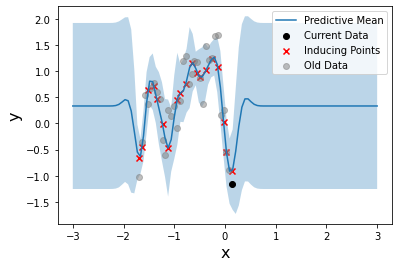

Starting step:  33
Loss:  tensor(6.1828, grad_fn=<NegBackward>)
Loss:  tensor(6.1341, grad_fn=<NegBackward>)
Loss:  tensor(6.1291, grad_fn=<NegBackward>)
Loss:  tensor(6.1482, grad_fn=<NegBackward>)
Loss:  tensor(6.1402, grad_fn=<NegBackward>)
Loss:  tensor(6.1218, grad_fn=<NegBackward>)
Loss:  tensor(6.1214, grad_fn=<NegBackward>)
Loss:  tensor(6.1257, grad_fn=<NegBackward>)
Loss:  tensor(6.1127, grad_fn=<NegBackward>)
Loss:  tensor(6.0980, grad_fn=<NegBackward>)
Starting step:  34
Loss:  tensor(5.9939, grad_fn=<NegBackward>)
Loss:  tensor(5.9708, grad_fn=<NegBackward>)
Loss:  tensor(5.9684, grad_fn=<NegBackward>)
Loss:  tensor(5.9584, grad_fn=<NegBackward>)
Loss:  tensor(5.9408, grad_fn=<NegBackward>)
Loss:  tensor(5.9397, grad_fn=<NegBackward>)
Loss:  tensor(5.9325, grad_fn=<NegBackward>)
Loss:  tensor(5.9160, grad_fn=<NegBackward>)
Loss:  tensor(5.9092, grad_fn=<NegBackward>)
Loss:  tensor(5.9009, grad_fn=<NegBackward>)


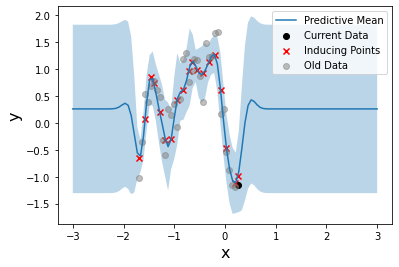

Starting step:  35
Loss:  tensor(5.4439, grad_fn=<NegBackward>)
Loss:  tensor(5.4187, grad_fn=<NegBackward>)
Loss:  tensor(5.4040, grad_fn=<NegBackward>)
Loss:  tensor(5.3949, grad_fn=<NegBackward>)
Loss:  tensor(5.3742, grad_fn=<NegBackward>)
Loss:  tensor(5.3551, grad_fn=<NegBackward>)
Loss:  tensor(5.3448, grad_fn=<NegBackward>)
Loss:  tensor(5.3329, grad_fn=<NegBackward>)
Loss:  tensor(5.3212, grad_fn=<NegBackward>)
Loss:  tensor(5.3116, grad_fn=<NegBackward>)
Starting step:  36
Loss:  tensor(8.3426, grad_fn=<NegBackward>)
Loss:  tensor(8.3059, grad_fn=<NegBackward>)
Loss:  tensor(8.2543, grad_fn=<NegBackward>)
Loss:  tensor(8.1896, grad_fn=<NegBackward>)
Loss:  tensor(8.1109, grad_fn=<NegBackward>)
Loss:  tensor(8.0385, grad_fn=<NegBackward>)
Loss:  tensor(7.9839, grad_fn=<NegBackward>)
Loss:  tensor(7.9365, grad_fn=<NegBackward>)
Loss:  tensor(7.8919, grad_fn=<NegBackward>)
Loss:  tensor(7.8566, grad_fn=<NegBackward>)


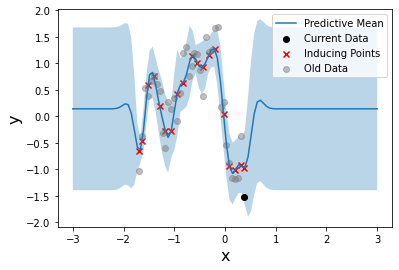

Starting step:  37
Loss:  tensor(5.3013, grad_fn=<NegBackward>)
Loss:  tensor(5.2913, grad_fn=<NegBackward>)
Loss:  tensor(5.2881, grad_fn=<NegBackward>)
Loss:  tensor(5.2800, grad_fn=<NegBackward>)
Loss:  tensor(5.2698, grad_fn=<NegBackward>)
Loss:  tensor(5.2628, grad_fn=<NegBackward>)
Loss:  tensor(5.2510, grad_fn=<NegBackward>)
Loss:  tensor(5.2392, grad_fn=<NegBackward>)
Loss:  tensor(5.2307, grad_fn=<NegBackward>)
Loss:  tensor(5.2190, grad_fn=<NegBackward>)
Starting step:  38
Loss:  tensor(6.1190, grad_fn=<NegBackward>)
Loss:  tensor(6.0979, grad_fn=<NegBackward>)
Loss:  tensor(6.0749, grad_fn=<NegBackward>)
Loss:  tensor(6.0518, grad_fn=<NegBackward>)
Loss:  tensor(6.0193, grad_fn=<NegBackward>)
Loss:  tensor(5.9889, grad_fn=<NegBackward>)
Loss:  tensor(5.9644, grad_fn=<NegBackward>)
Loss:  tensor(5.9385, grad_fn=<NegBackward>)
Loss:  tensor(5.9146, grad_fn=<NegBackward>)
Loss:  tensor(5.8932, grad_fn=<NegBackward>)


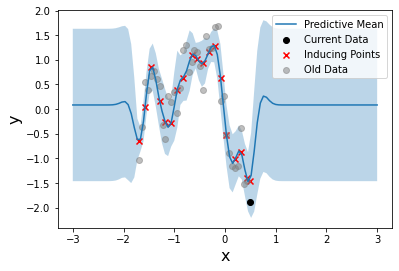

Starting step:  39
Loss:  tensor(8.1366, grad_fn=<NegBackward>)
Loss:  tensor(8.0163, grad_fn=<NegBackward>)
Loss:  tensor(7.8955, grad_fn=<NegBackward>)
Loss:  tensor(7.7386, grad_fn=<NegBackward>)
Loss:  tensor(7.5795, grad_fn=<NegBackward>)
Loss:  tensor(7.4255, grad_fn=<NegBackward>)
Loss:  tensor(7.2574, grad_fn=<NegBackward>)
Loss:  tensor(7.1091, grad_fn=<NegBackward>)
Loss:  tensor(6.9686, grad_fn=<NegBackward>)
Loss:  tensor(6.8340, grad_fn=<NegBackward>)
Starting step:  40
Loss:  tensor(23.4465, grad_fn=<NegBackward>)
Loss:  tensor(21.5055, grad_fn=<NegBackward>)
Loss:  tensor(19.2895, grad_fn=<NegBackward>)
Loss:  tensor(16.9969, grad_fn=<NegBackward>)
Loss:  tensor(15.0868, grad_fn=<NegBackward>)
Loss:  tensor(13.4038, grad_fn=<NegBackward>)
Loss:  tensor(12.2232, grad_fn=<NegBackward>)
Loss:  tensor(11.3845, grad_fn=<NegBackward>)
Loss:  tensor(10.8696, grad_fn=<NegBackward>)
Loss:  tensor(10.5872, grad_fn=<NegBackward>)


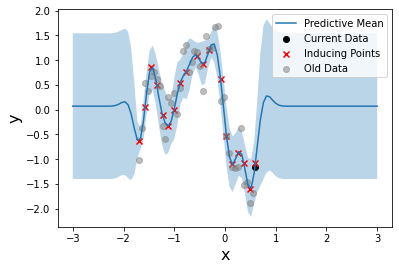

Starting step:  41
Loss:  tensor(6.3943, grad_fn=<NegBackward>)
Loss:  tensor(6.3396, grad_fn=<NegBackward>)
Loss:  tensor(6.4253, grad_fn=<NegBackward>)
Loss:  tensor(6.5670, grad_fn=<NegBackward>)
Loss:  tensor(6.7052, grad_fn=<NegBackward>)
Loss:  tensor(6.8149, grad_fn=<NegBackward>)
Loss:  tensor(6.8834, grad_fn=<NegBackward>)
Loss:  tensor(6.9016, grad_fn=<NegBackward>)
Loss:  tensor(6.8563, grad_fn=<NegBackward>)
Loss:  tensor(6.7526, grad_fn=<NegBackward>)
Starting step:  42
Loss:  tensor(5.0478, grad_fn=<NegBackward>)
Loss:  tensor(4.9900, grad_fn=<NegBackward>)
Loss:  tensor(4.9708, grad_fn=<NegBackward>)
Loss:  tensor(4.9976, grad_fn=<NegBackward>)
Loss:  tensor(5.0059, grad_fn=<NegBackward>)
Loss:  tensor(4.9680, grad_fn=<NegBackward>)
Loss:  tensor(4.9241, grad_fn=<NegBackward>)
Loss:  tensor(4.9098, grad_fn=<NegBackward>)
Loss:  tensor(4.9074, grad_fn=<NegBackward>)
Loss:  tensor(4.8844, grad_fn=<NegBackward>)


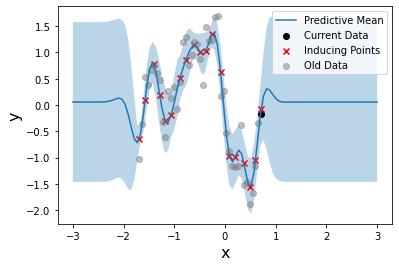

Starting step:  43
Loss:  tensor(4.7986, grad_fn=<NegBackward>)
Loss:  tensor(4.7775, grad_fn=<NegBackward>)
Loss:  tensor(4.7581, grad_fn=<NegBackward>)
Loss:  tensor(4.7471, grad_fn=<NegBackward>)
Loss:  tensor(4.7327, grad_fn=<NegBackward>)
Loss:  tensor(4.7067, grad_fn=<NegBackward>)
Loss:  tensor(4.6750, grad_fn=<NegBackward>)
Loss:  tensor(4.6448, grad_fn=<NegBackward>)
Loss:  tensor(4.6170, grad_fn=<NegBackward>)
Loss:  tensor(4.5882, grad_fn=<NegBackward>)
Starting step:  44
Loss:  tensor(5.6579, grad_fn=<NegBackward>)
Loss:  tensor(5.6022, grad_fn=<NegBackward>)
Loss:  tensor(5.5820, grad_fn=<NegBackward>)
Loss:  tensor(5.5522, grad_fn=<NegBackward>)
Loss:  tensor(5.5137, grad_fn=<NegBackward>)
Loss:  tensor(5.4947, grad_fn=<NegBackward>)
Loss:  tensor(5.4755, grad_fn=<NegBackward>)
Loss:  tensor(5.4507, grad_fn=<NegBackward>)
Loss:  tensor(5.4283, grad_fn=<NegBackward>)
Loss:  tensor(5.4115, grad_fn=<NegBackward>)


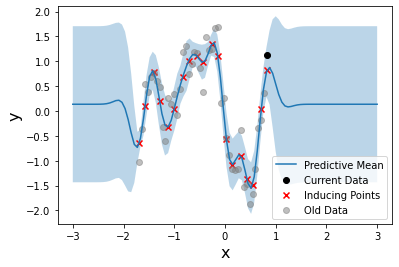

Starting step:  45
Loss:  tensor(4.6162, grad_fn=<NegBackward>)
Loss:  tensor(4.5769, grad_fn=<NegBackward>)
Loss:  tensor(4.5888, grad_fn=<NegBackward>)
Loss:  tensor(4.5603, grad_fn=<NegBackward>)
Loss:  tensor(4.5418, grad_fn=<NegBackward>)
Loss:  tensor(4.5328, grad_fn=<NegBackward>)
Loss:  tensor(4.5246, grad_fn=<NegBackward>)
Loss:  tensor(4.5116, grad_fn=<NegBackward>)
Loss:  tensor(4.5050, grad_fn=<NegBackward>)
Loss:  tensor(4.5082, grad_fn=<NegBackward>)
Starting step:  46
Loss:  tensor(4.0941, grad_fn=<NegBackward>)
Loss:  tensor(4.0645, grad_fn=<NegBackward>)
Loss:  tensor(4.0645, grad_fn=<NegBackward>)
Loss:  tensor(4.0555, grad_fn=<NegBackward>)
Loss:  tensor(4.0425, grad_fn=<NegBackward>)
Loss:  tensor(4.0288, grad_fn=<NegBackward>)
Loss:  tensor(4.0234, grad_fn=<NegBackward>)
Loss:  tensor(4.0203, grad_fn=<NegBackward>)
Loss:  tensor(4.0089, grad_fn=<NegBackward>)
Loss:  tensor(4.0077, grad_fn=<NegBackward>)


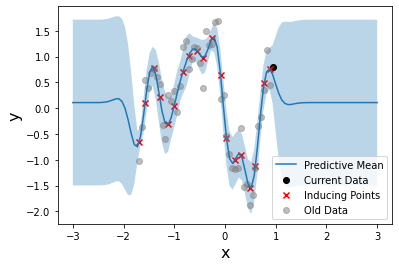

Starting step:  47
Loss:  tensor(4.3316, grad_fn=<NegBackward>)
Loss:  tensor(4.3070, grad_fn=<NegBackward>)
Loss:  tensor(4.2975, grad_fn=<NegBackward>)
Loss:  tensor(4.2852, grad_fn=<NegBackward>)
Loss:  tensor(4.2638, grad_fn=<NegBackward>)
Loss:  tensor(4.2476, grad_fn=<NegBackward>)
Loss:  tensor(4.2377, grad_fn=<NegBackward>)
Loss:  tensor(4.2251, grad_fn=<NegBackward>)
Loss:  tensor(4.2084, grad_fn=<NegBackward>)
Loss:  tensor(4.1968, grad_fn=<NegBackward>)
Starting step:  48
Loss:  tensor(14.2761, grad_fn=<NegBackward>)
Loss:  tensor(13.7847, grad_fn=<NegBackward>)
Loss:  tensor(13.1840, grad_fn=<NegBackward>)
Loss:  tensor(12.4265, grad_fn=<NegBackward>)
Loss:  tensor(11.6952, grad_fn=<NegBackward>)
Loss:  tensor(11.0028, grad_fn=<NegBackward>)
Loss:  tensor(10.4051, grad_fn=<NegBackward>)
Loss:  tensor(9.9191, grad_fn=<NegBackward>)
Loss:  tensor(9.5677, grad_fn=<NegBackward>)
Loss:  tensor(9.3027, grad_fn=<NegBackward>)


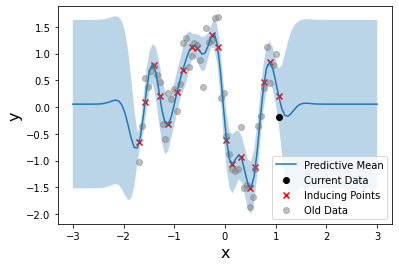

Starting step:  49
Loss:  tensor(5.3859, grad_fn=<NegBackward>)
Loss:  tensor(5.2713, grad_fn=<NegBackward>)
Loss:  tensor(5.2672, grad_fn=<NegBackward>)
Loss:  tensor(5.3116, grad_fn=<NegBackward>)
Loss:  tensor(5.3336, grad_fn=<NegBackward>)
Loss:  tensor(5.3601, grad_fn=<NegBackward>)
Loss:  tensor(5.4069, grad_fn=<NegBackward>)
Loss:  tensor(5.4416, grad_fn=<NegBackward>)
Loss:  tensor(5.4427, grad_fn=<NegBackward>)
Loss:  tensor(5.4223, grad_fn=<NegBackward>)
Starting step:  50
Loss:  tensor(3.9989, grad_fn=<NegBackward>)
Loss:  tensor(3.8537, grad_fn=<NegBackward>)
Loss:  tensor(3.9451, grad_fn=<NegBackward>)
Loss:  tensor(3.9629, grad_fn=<NegBackward>)
Loss:  tensor(3.8219, grad_fn=<NegBackward>)
Loss:  tensor(3.7935, grad_fn=<NegBackward>)
Loss:  tensor(3.8218, grad_fn=<NegBackward>)
Loss:  tensor(3.7401, grad_fn=<NegBackward>)
Loss:  tensor(3.6406, grad_fn=<NegBackward>)
Loss:  tensor(3.6298, grad_fn=<NegBackward>)


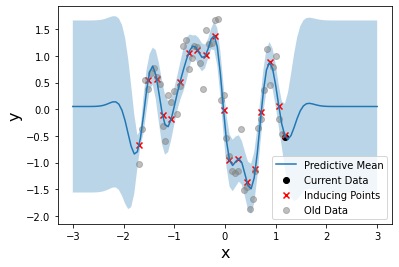

Starting step:  51
Loss:  tensor(5.0826, grad_fn=<NegBackward>)
Loss:  tensor(4.9775, grad_fn=<NegBackward>)
Loss:  tensor(4.9668, grad_fn=<NegBackward>)
Loss:  tensor(4.9730, grad_fn=<NegBackward>)
Loss:  tensor(4.8974, grad_fn=<NegBackward>)
Loss:  tensor(4.8374, grad_fn=<NegBackward>)
Loss:  tensor(4.8381, grad_fn=<NegBackward>)
Loss:  tensor(4.8111, grad_fn=<NegBackward>)
Loss:  tensor(4.7494, grad_fn=<NegBackward>)
Loss:  tensor(4.7227, grad_fn=<NegBackward>)
Starting step:  52
Loss:  tensor(0.4885, grad_fn=<NegBackward>)
Loss:  tensor(0.4898, grad_fn=<NegBackward>)
Loss:  tensor(0.4856, grad_fn=<NegBackward>)
Loss:  tensor(0.4698, grad_fn=<NegBackward>)
Loss:  tensor(0.4647, grad_fn=<NegBackward>)
Loss:  tensor(0.4619, grad_fn=<NegBackward>)
Loss:  tensor(0.4496, grad_fn=<NegBackward>)
Loss:  tensor(0.4408, grad_fn=<NegBackward>)
Loss:  tensor(0.4388, grad_fn=<NegBackward>)
Loss:  tensor(0.4323, grad_fn=<NegBackward>)


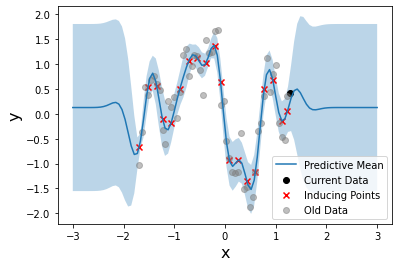

Starting step:  53
Loss:  tensor(6.3841, grad_fn=<NegBackward>)
Loss:  tensor(6.3366, grad_fn=<NegBackward>)
Loss:  tensor(6.3101, grad_fn=<NegBackward>)
Loss:  tensor(6.2942, grad_fn=<NegBackward>)
Loss:  tensor(6.2192, grad_fn=<NegBackward>)
Loss:  tensor(6.1328, grad_fn=<NegBackward>)
Loss:  tensor(6.0761, grad_fn=<NegBackward>)
Loss:  tensor(6.0044, grad_fn=<NegBackward>)
Loss:  tensor(5.9087, grad_fn=<NegBackward>)
Loss:  tensor(5.8327, grad_fn=<NegBackward>)
Starting step:  54
Loss:  tensor(3.9341, grad_fn=<NegBackward>)
Loss:  tensor(3.8837, grad_fn=<NegBackward>)
Loss:  tensor(3.9144, grad_fn=<NegBackward>)
Loss:  tensor(3.9728, grad_fn=<NegBackward>)
Loss:  tensor(3.9553, grad_fn=<NegBackward>)
Loss:  tensor(3.9186, grad_fn=<NegBackward>)
Loss:  tensor(3.9379, grad_fn=<NegBackward>)
Loss:  tensor(3.9600, grad_fn=<NegBackward>)
Loss:  tensor(3.9330, grad_fn=<NegBackward>)
Loss:  tensor(3.9056, grad_fn=<NegBackward>)


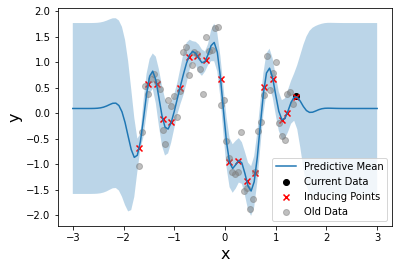

Starting step:  55
Loss:  tensor(7.9526, grad_fn=<NegBackward>)
Loss:  tensor(7.8397, grad_fn=<NegBackward>)
Loss:  tensor(7.8439, grad_fn=<NegBackward>)
Loss:  tensor(7.7797, grad_fn=<NegBackward>)
Loss:  tensor(7.5857, grad_fn=<NegBackward>)
Loss:  tensor(7.4512, grad_fn=<NegBackward>)
Loss:  tensor(7.4058, grad_fn=<NegBackward>)
Loss:  tensor(7.3060, grad_fn=<NegBackward>)
Loss:  tensor(7.1648, grad_fn=<NegBackward>)
Loss:  tensor(7.0930, grad_fn=<NegBackward>)
Starting step:  56
Loss:  tensor(6.0642, grad_fn=<NegBackward>)
Loss:  tensor(5.9200, grad_fn=<NegBackward>)
Loss:  tensor(5.9044, grad_fn=<NegBackward>)
Loss:  tensor(5.8768, grad_fn=<NegBackward>)
Loss:  tensor(5.7693, grad_fn=<NegBackward>)
Loss:  tensor(5.7181, grad_fn=<NegBackward>)
Loss:  tensor(5.7241, grad_fn=<NegBackward>)
Loss:  tensor(5.6750, grad_fn=<NegBackward>)
Loss:  tensor(5.6106, grad_fn=<NegBackward>)
Loss:  tensor(5.6035, grad_fn=<NegBackward>)


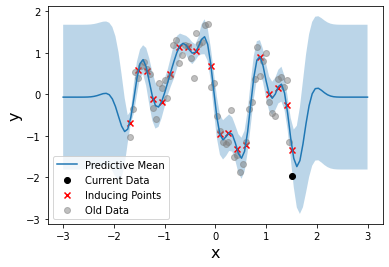

Starting step:  57
Loss:  tensor(4.9310, grad_fn=<NegBackward>)
Loss:  tensor(4.8748, grad_fn=<NegBackward>)
Loss:  tensor(4.9052, grad_fn=<NegBackward>)
Loss:  tensor(4.8851, grad_fn=<NegBackward>)
Loss:  tensor(4.8553, grad_fn=<NegBackward>)
Loss:  tensor(4.8790, grad_fn=<NegBackward>)
Loss:  tensor(4.8530, grad_fn=<NegBackward>)
Loss:  tensor(4.8347, grad_fn=<NegBackward>)
Loss:  tensor(4.8445, grad_fn=<NegBackward>)
Loss:  tensor(4.8194, grad_fn=<NegBackward>)
Starting step:  58
Loss:  tensor(16.8277, grad_fn=<NegBackward>)
Loss:  tensor(16.3118, grad_fn=<NegBackward>)
Loss:  tensor(15.3880, grad_fn=<NegBackward>)
Loss:  tensor(14.2476, grad_fn=<NegBackward>)
Loss:  tensor(13.0529, grad_fn=<NegBackward>)
Loss:  tensor(11.9525, grad_fn=<NegBackward>)
Loss:  tensor(11.0344, grad_fn=<NegBackward>)
Loss:  tensor(10.3356, grad_fn=<NegBackward>)
Loss:  tensor(9.8620, grad_fn=<NegBackward>)
Loss:  tensor(9.5941, grad_fn=<NegBackward>)


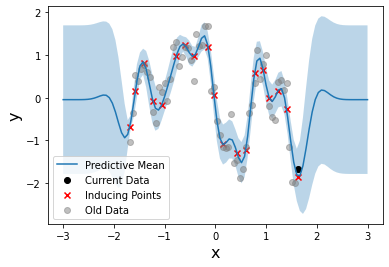

Starting step:  59
Loss:  tensor(13.4182, grad_fn=<NegBackward>)
Loss:  tensor(12.3192, grad_fn=<NegBackward>)
Loss:  tensor(12.7954, grad_fn=<NegBackward>)
Loss:  tensor(12.4947, grad_fn=<NegBackward>)
Loss:  tensor(12.2455, grad_fn=<NegBackward>)
Loss:  tensor(12.8491, grad_fn=<NegBackward>)
Loss:  tensor(12.8082, grad_fn=<NegBackward>)
Loss:  tensor(12.4471, grad_fn=<NegBackward>)
Loss:  tensor(12.6433, grad_fn=<NegBackward>)
Loss:  tensor(12.5713, grad_fn=<NegBackward>)


In [10]:
step = 1

for i in range(25, 60, step):
    print("Starting step: ", i)
    next_x = inputs[i:i+step]
    next_y = targets[i:i+step]
    
    with gpytorch.settings.cholesky_jitter(1e-3):
        vargp_model.update_variational_parameters(
            next_x, 
            next_y, 
            _pivoted_cholesky_init(inputs[:(i+step)], cm(inputs[:(i+step)]), 19)
        )
    
    vargp_model.zero_grad()
    vargp_model.train()

    mll = gpytorch.mlls.VariationalELBO(
        likelihood=likelihood, 
        model=vargp_model, 
        num_data=step, 
        beta = 1.0,
        combine_terms=True
    )
    
    fit_model(mll, vargp_model, optimizer, next_x, next_y, num_steps=10, verbose=True)
    
    if i % 2 == 0:
        make_basic_plot(
            vargp_model, 
            next_x, 
            next_y, 
            old_x=inputs[:i], 
            old_y=targets[:i], 
            bounds=(-3., 3.)
        )
        plt.show()


## Fit in Online Mode (Coreset-Like)


In [7]:

cm = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
vargp_model = online_gp.models.VariationalGPModel(
    _pivoted_cholesky_init(inputs[:25], cm(inputs[:25]), 20), 
    streaming=False, 
    likelihood = likelihood,
    covar_module = cm,
    learn_inducing_locations=False,
)
mll = gpytorch.mlls.VariationalELBO(likelihood=likelihood, model=vargp_model, num_data=25, beta = 1.0)

optimizer = torch.optim.Adam(list(vargp_model.parameters()) + list(likelihood.parameters()), lr = 1e-2)

fit_model(mll, vargp_model, optimizer, inputs[:25], targets[:25])



/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/torch/optim/adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Loss:  tensor(2.7005, grad_fn=<NegBackward>)
Loss:  tensor(1.2510, grad_fn=<NegBackward>)
Loss:  tensor(0.8699, grad_fn=<NegBackward>)
Loss:  tensor(0.7385, grad_fn=<NegBackward>)
Loss:  tensor(0.7277, grad_fn=<NegBackward>)
Loss:  tensor(0.7275, grad_fn=<NegBackward>)
Loss:  tensor(0.7275, grad_fn=<NegBackward>)
Loss:  tensor(0.7277, grad_fn=<NegBackward>)
Loss:  tensor(0.7277, grad_fn=<NegBackward>)
Loss:  tensor(0.7275, grad_fn=<NegBackward>)


/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  after removing the cwd from sys.path.


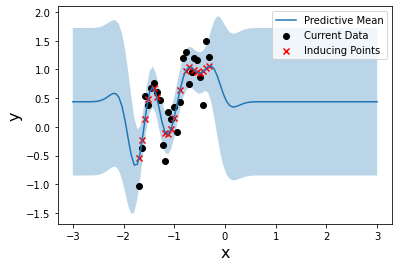

In [8]:
make_basic_plot(vargp_model, inputs[:25], targets[:25], bounds=(-3., 3))

In [9]:
%pdb

Automatic pdb calling has been turned ON


Starting step:  25
Loss:  tensor(1.0814, grad_fn=<NegBackward>)
Loss:  tensor(1.1569, grad_fn=<NegBackward>)
Loss:  tensor(1.3345, grad_fn=<NegBackward>)
Loss:  tensor(2.9381, grad_fn=<NegBackward>)


/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Loss:  tensor(2.5862, grad_fn=<NegBackward>)
Loss:  tensor(2.7620, grad_fn=<NegBackward>)
Loss:  tensor(2.1106, grad_fn=<NegBackward>)
Loss:  tensor(2.0388, grad_fn=<NegBackward>)
Loss:  tensor(1.9243, grad_fn=<NegBackward>)
Loss:  tensor(1.8464, grad_fn=<NegBackward>)
Starting step:  30
Loss:  tensor(1.5802, grad_fn=<NegBackward>)
Loss:  tensor(1.5667, grad_fn=<NegBackward>)
Loss:  tensor(1.6438, grad_fn=<NegBackward>)
Loss:  tensor(1.6520, grad_fn=<NegBackward>)
Loss:  tensor(1.6307, grad_fn=<NegBackward>)
Loss:  tensor(1.5760, grad_fn=<NegBackward>)
Loss:  tensor(1.5127, grad_fn=<NegBackward>)
Loss:  tensor(1.4858, grad_fn=<NegBackward>)
Loss:  tensor(1.4678, grad_fn=<NegBackward>)
Loss:  tensor(1.4135, grad_fn=<NegBackward>)


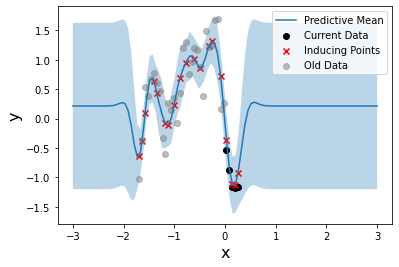

Starting step:  35
Loss:  tensor(1.7084, grad_fn=<NegBackward>)
Loss:  tensor(1.6833, grad_fn=<NegBackward>)
Loss:  tensor(1.6729, grad_fn=<NegBackward>)
Loss:  tensor(1.6524, grad_fn=<NegBackward>)
Loss:  tensor(1.6272, grad_fn=<NegBackward>)
Loss:  tensor(1.6047, grad_fn=<NegBackward>)
Loss:  tensor(1.5760, grad_fn=<NegBackward>)
Loss:  tensor(1.5424, grad_fn=<NegBackward>)
Loss:  tensor(1.5107, grad_fn=<NegBackward>)
Loss:  tensor(1.4807, grad_fn=<NegBackward>)
Starting step:  40
Loss:  tensor(0.9098, grad_fn=<NegBackward>)
Loss:  tensor(0.8671, grad_fn=<NegBackward>)
Loss:  tensor(0.8210, grad_fn=<NegBackward>)
Loss:  tensor(0.7743, grad_fn=<NegBackward>)
Loss:  tensor(0.7275, grad_fn=<NegBackward>)
Loss:  tensor(0.6800, grad_fn=<NegBackward>)
Loss:  tensor(0.6323, grad_fn=<NegBackward>)
Loss:  tensor(0.5871, grad_fn=<NegBackward>)
Loss:  tensor(0.5464, grad_fn=<NegBackward>)
Loss:  tensor(0.5085, grad_fn=<NegBackward>)


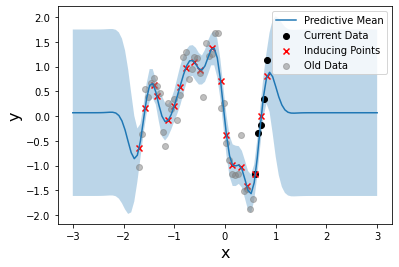

Starting step:  45
Loss:  tensor(0.9607, grad_fn=<NegBackward>)
Loss:  tensor(0.9582, grad_fn=<NegBackward>)
Loss:  tensor(0.9658, grad_fn=<NegBackward>)
Loss:  tensor(0.9709, grad_fn=<NegBackward>)
Loss:  tensor(0.9669, grad_fn=<NegBackward>)
Loss:  tensor(0.9589, grad_fn=<NegBackward>)
Loss:  tensor(0.9533, grad_fn=<NegBackward>)
Loss:  tensor(0.9471, grad_fn=<NegBackward>)
Loss:  tensor(0.9370, grad_fn=<NegBackward>)
Loss:  tensor(0.9280, grad_fn=<NegBackward>)
Starting step:  50
Loss:  tensor(0.7890, grad_fn=<NegBackward>)
Loss:  tensor(0.7921, grad_fn=<NegBackward>)
Loss:  tensor(0.7971, grad_fn=<NegBackward>)
Loss:  tensor(0.8011, grad_fn=<NegBackward>)
Loss:  tensor(0.8019, grad_fn=<NegBackward>)
Loss:  tensor(0.8006, grad_fn=<NegBackward>)
Loss:  tensor(0.7993, grad_fn=<NegBackward>)
Loss:  tensor(0.7984, grad_fn=<NegBackward>)
Loss:  tensor(0.7971, grad_fn=<NegBackward>)
Loss:  tensor(0.7952, grad_fn=<NegBackward>)


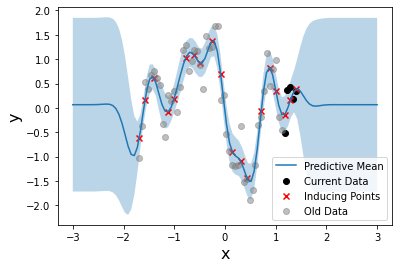

Starting step:  55
Loss:  tensor(1.9278, grad_fn=<NegBackward>)
Loss:  tensor(1.9032, grad_fn=<NegBackward>)
Loss:  tensor(1.8720, grad_fn=<NegBackward>)
Loss:  tensor(1.8409, grad_fn=<NegBackward>)
Loss:  tensor(1.8130, grad_fn=<NegBackward>)
Loss:  tensor(1.7899, grad_fn=<NegBackward>)
Loss:  tensor(1.7725, grad_fn=<NegBackward>)
Loss:  tensor(1.7611, grad_fn=<NegBackward>)
Loss:  tensor(1.7548, grad_fn=<NegBackward>)
Loss:  tensor(1.7524, grad_fn=<NegBackward>)


In [10]:
step = 5

for i in range(25, 60, step):
    print("Starting step: ", i)
    next_x = inputs[i:i+step]
    next_y = targets[i:i+step]
    
    with gpytorch.settings.cholesky_jitter(1e-3):
        stacked_data = torch.cat((next_x, vargp_model.variational_strategy.inducing_points.detach()))
        
        vargp_model.update_variational_parameters(
            next_x, 
            next_y, 
            _pivoted_cholesky_init(stacked_data, cm(stacked_data), 19)
        )
    
    vargp_model.zero_grad()
    vargp_model.train()

    mll = gpytorch.mlls.VariationalELBO(
        likelihood=likelihood, 
        model=vargp_model, 
        num_data=step, 
        beta = 1.0,
        combine_terms=True
    )
    
    fit_model(mll, vargp_model, optimizer, next_x, next_y, num_steps=10, verbose=True)
    
    if i % 2 == 0:
        make_basic_plot(
            vargp_model, 
            next_x, 
            next_y, 
            old_x=inputs[:i], 
            old_y=targets[:i], 
            bounds=(-3., 3.)
        )
        plt.show()


In [16]:
stacked_data.shape

torch.Size([20, 1])